In [1]:
import os
from os import walk

import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import yaml

from collections import Counter

import sys
sys.path.append('../parsing_and_plotting/')
from parse_data import * 

%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)


#Set seaborn color palette:
palette_list = list(sns.color_palette("colorblind"))
#change order
palette_list = [sns.color_palette('colorblind')[3]] + [sns.color_palette('colorblind')[0]] + [sns.color_palette('colorblind')[2]] + [sns.color_palette('colorblind')[1]]

# Load Typing Results

In [2]:
#Make function for conversion, to be used in this run of the notebook:
p_group_dict = make_p_group_dict()
e_group_dict = make_e_group_dict()

def convert_allele(allele, resolution = 'two_field'):

    """
    input:
    allele (str): An allele in the format (A|B|C|DRB1|DQB1)\*\d{2}:\d{2,3}:?\d{0,3}G?:?\d{0,3} to be converted.
    resolution:   the resolution, with which the allele is converted to

    """
    if resolution == "one_field":
        converted_allele = convert_to_one_field(allele)
    
    elif resolution == "two_field":
        converted_allele = convert_to_two_field(allele)
        
    elif resolution == "p_group":
        converted_allele = convert_to_p_group(allele, p_group_dict=p_group_dict)
    
    elif resolution == "e_group":
        converted_allele = convert_to_e_group(allele, e_group_dict=e_group_dict, p_group_dict=p_group_dict)
            
    else:
        print("A conversion mistake happend. Please specify a correct conversion type.")
        converted_allele = None
        
    return converted_allele      

In [3]:
def define_resultpath(read_length='65', coverage='50', damage='no_dmg'):
    if damage == 'dmg':
        resultpath = f'results/damaged_reads/{read_length}_read_length/{coverage}X_coverage/'
    else:
        resultpath = f'results/no_damage/{read_length}_read_length/{coverage}X_coverage/'

    return resultpath

def load_optitype_results(optitype_result_filepath):

    optitype_files = []
    for (dirpath, dirnames, filenames) in walk(optitype_result_filepath):
        optitype_files.extend(filenames)

    #print(optitype_files)

    optitype_results_reads = dict()

    for filename in optitype_files:
        #Check for right file, and that the file is not empty
        if (filename.endswith('.tsv')) and (os.stat(optitype_result_filepath + filename).st_size != 0):
            n_reads = list(pd.read_csv(optitype_result_filepath + filename, sep = "\t").iloc[0])[7]
            optitype_results_reads[filename[:-11]] = str(n_reads)


        #Add empty entry for empty file
        elif (filename.endswith('.tsv')) and (os.stat(optitype_result_filepath + filename).st_size == 0):
            optitype_results_reads[filename[:-11]] = '0'

    return optitype_results_reads

In [4]:
# optitype_results_reads = dict()

read_lengths = ["13", "15", '20', '25','30','35', '45', '55', '65']
coverages = ['1', '2','5', '10', '20', "50"]

# for dmg in ['dmg', 'no_dmg']:
#     optitype_results_reads[dmg] = dict()
#     for rl in read_lengths:
#         optitype_results_reads[dmg][rl] = dict()
#         for cov in coverages:
#             optitype_results_reads[dmg][rl][cov] = load_optitype_results(define_resultpath(read_length=rl, coverage=cov, damage=dmg))

# with open('results/optitype_n_reads.json', 'w') as outfile:
#     json.dump(optitype_results_reads, outfile)

with open('results/optitype_n_reads.json', 'r') as infile:
    optitype_results_reads = json.load(infile)

In [5]:
median_n_reads_dict = dict()

for dmg in ['dmg', 'no_dmg']:
    median_n_reads_dict[dmg] = dict()
    for rl in read_lengths:
        median_n_reads_dict[dmg][rl] = dict()
        for cov in coverages:
            median_n_reads_dict[dmg][rl][cov] = np.median([int(n_reads) for n_reads in optitype_results_reads[dmg][rl][cov].values()])



/home/nthu/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nthu/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
median_n_reads_dict

{'dmg': {'13': {'1': 96.5,
   '2': 189.0,
   '5': 456.5,
   '10': 922.0,
   '20': 1829.5,
   '50': nan},
  '15': {'1': 80.5,
   '2': 156.0,
   '5': 384.0,
   '10': 766.5,
   '20': 1534.5,
   '50': nan},
  '20': {'1': 53.5,
   '2': 107.0,
   '5': 264.0,
   '10': 518.0,
   '20': 1036.0,
   '50': 2700.5},
  '25': {'1': 42.0,
   '2': 81.5,
   '5': 199.5,
   '10': 395.5,
   '20': 785.5,
   '50': 1961.5},
  '30': {'1': 32.0,
   '2': 62.5,
   '5': 156.0,
   '10': 304.0,
   '20': 614.0,
   '50': 1529.5},
  '35': {'1': 36.0,
   '2': 68.5,
   '5': 171.5,
   '10': 331.5,
   '20': 662.0,
   '50': 1661.0},
  '45': {'1': 24.0,
   '2': 49.5,
   '5': 122.0,
   '10': 241.5,
   '20': 487.5,
   '50': 1201.0},
  '55': {'1': 17.5,
   '2': 37.5,
   '5': 91.0,
   '10': 183.0,
   '20': 358.0,
   '50': 877.5},
  '65': {'1': 13.0,
   '2': 26.0,
   '5': 64.5,
   '10': 129.0,
   '20': 257.0,
   '50': 647.5}},
 'no_dmg': {'13': {'1': 109.0,
   '2': 218.0,
   '5': 533.0,
   '10': 1081.5,
   '20': 2151.5,
   '50': n

In [9]:
def performance_coverage_plot(median_n_reads_dict, coverage_list, resolution = 'two_field', alleles=['A', 'B', 'C'], ):


    n_reads_dict = dict()
    call_rate_dict = dict()

    for dmg, read_length_dict in median_n_reads_dict.items():
        if dmg == 'no_dmg':
            dmg_str = ''
        else:
            dmg_str = '+dmg'

        for rl, coverage_dict in read_length_dict.items():

            n_reads_dict[f'{rl}{dmg_str}'] = dict()
            call_rate_dict[f'{rl}{dmg_str}'] = dict()

            for cov,_ in coverage_dict.items():
                if not np.isnan(median_n_reads_dict[dmg][rl][cov]):
                    n_reads_dict[f'{rl}{dmg_str}'][int(cov)] = median_n_reads_dict[dmg][rl][cov]

    n_reads_df = pd.DataFrame(n_reads_dict)
    n_reads_df = n_reads_df[n_reads_df.index.isin(coverage_list)]

    fig, axs = plt.subplot_mosaic([['(A)']], constrained_layout=True, figsize=(15,12))
    ax = axs['(A)']
    title = "The impact of read length on Optitype's typing 2-field typing accuracy"
    rl_df = n_reads_df[["13", "25", "45", "65"]]
    rl_df.plot(marker='o', ax=ax, color = palette_list, sharey=True, ms=10)

    dmg_df = n_reads_df[["13+dmg", "25+dmg", "45+dmg", "65+dmg"]]
    dmg_df.plot(marker="^", ax=ax, color = palette_list, sharey=True, ms=10, style='--')

    ax.set_xlabel("Coverage (X)", size=20)
    ax.set_ylabel("Median number of explained reads by Optitype", size=20)
        
    ax.set_xticks([int(cov) for cov in coverage_list],)
    ax.set_xticklabels(coverage_list, size=20)
    #ax.set_yticks(list(range(0,101,10)), size=20)
    ax.yaxis.grid()
    ax.set_title(title)
    
    plt.rcParams.update({'font.size': 20})
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=24)
    
    plt.title("")
    ax.set_yscale('log')
    
    legend = ax.legend(title="Read length", loc='lower right')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.tight_layout()   
    return fig, ax
    

/tmp/ipykernel_1005889/2492706812.py:57: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


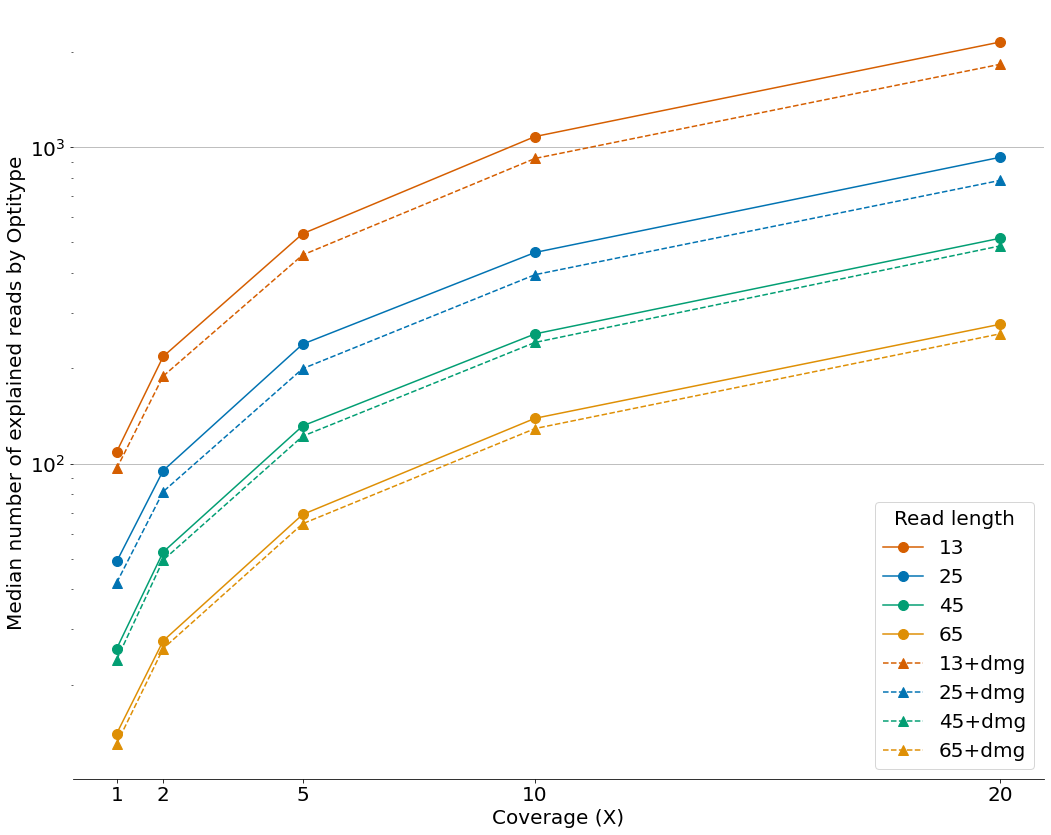

In [10]:
coverage_list = [1, 2, 5, 10, 20,]

fig, ax, = performance_coverage_plot(median_n_reads_dict, coverage_list=coverage_list)

fig.savefig('../parsing_and_plotting/plots/median_explained_reads_aDNA_optitype.tiff')

fig.savefig('../parsing_and_plotting/paper_plots/FigureS6.eps')